### CIFAR GAN

In [1]:
import tensorflow as tf
from keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy.random import random
from numpy import vstack
import numpy as np
from numpy.random import rand 
from keras.datasets.cifar10 import load_data
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
def prepare_cifar_data():
  (train_x, train_y), (test_x, test_y) = load_data()
  x = train_x.astype("float32") 
  x = (x - 127.5) / 127.5
  return x

In [3]:
dataset_1 = prepare_cifar_data()
dataset_1

170508288/170498071 [==============================] - 4s 0us/step


array([[[[-0.5372549 , -0.5137255 , -0.5058824 ],
         [-0.6627451 , -0.6392157 , -0.64705884],
         [-0.60784316, -0.62352943, -0.6627451 ],
         ...,
         [ 0.23921569,  0.03529412, -0.15294118],
         [ 0.19215687, -0.01960784, -0.2       ],
         [ 0.16078432, -0.02745098, -0.19215687]],

        [[-0.8745098 , -0.84313726, -0.84313726],
         [-1.        , -1.        , -1.        ],
         [-0.85882354, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.30980393, -0.5686275 ],
         [-0.06666667, -0.34901962, -0.60784316],
         [-0.04313726, -0.31764707, -0.5529412 ]],

        [[-0.8039216 , -0.8117647 , -0.8352941 ],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.6156863 , -0.7882353 , -0.9372549 ],
         ...,
         [-0.07450981, -0.34117648, -0.60784316],
         [-0.05882353, -0.34117648, -0.60784316],
         [-0.14509805, -0.42745098, -0.67058825]],

        ...,

        [[ 0.6313726 ,  0.33333334, -0

In [4]:
def discriminator_model(input_shape=(32,32,3)):
  model = Sequential()
  model.add(Conv2D(64,(3,3),padding="same",input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation="sigmoid"))
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
  return model

In [5]:
discriminator_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

In [6]:
def generate_real_samples(dataset, n_samples):
  index = randint(0, dataset.shape[0], n_samples)
  x = dataset[index]
  y = np.ones((n_samples,1))
  return x,y

In [7]:
def generator_model(latent_dim):
  model = Sequential()
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3,(3,3), activation="tanh",padding="same"))
  return model

In [8]:
generator_model(100).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [9]:
def generate_latent_points(latent_dim, n_samples):
  x = randn(latent_dim * n_samples)
  x = x.reshape(n_samples,latent_dim)
  return x

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples):
  latent_points = generate_latent_points(latent_dim, n_samples)
  x_fake = generator.predict(latent_points)
  y = np.zeros((n_samples,1))
  return x_fake,y

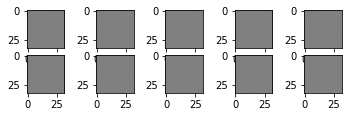

In [11]:
# Generating fake samples from untrained generator
latent_dim = 100
generator = generator_model(100)
x, _ = generate_fake_samples(generator, latent_dim, 49)
x = (x+1)/2.0
for i in range(10):
  plt.subplot(5,5,1+i)
  plt.imshow(x[i])
plt.show()

In [12]:
discriminator = discriminator_model()

In [13]:
def gan_model(generator, discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss="binary_crossentropy", optimizer = optimizer)
  return model

In [14]:
gan_model = gan_model(generator, discriminator)
gan_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [15]:
def summarize_model_performance(epoch, generator, discriminator,dataset,latent_dim,n_samples=150):
  x_real, y_real = generate_real_samples(dataset,n_samples)
  _, real_accuracy = discriminator.train_on_batch(x_real, y_real)
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
  _, fake_accuracy = discriminator.train_on_batch(x_fake, y_fake)
  print("Real accuracy is " + str(real_accuracy) + " Fake accuracy is " + str(fake_accuracy))
  x_fake = (x_fake+1) / 2.0
  for j in range(5*5):
    plt.subplot(5,5,j+1)
    plt.axis("off")
    plt.imshow(x_fake[i])
  file_name = "generated_plot_e%03d.png" % (epoch+1)
  plt.savefig(file_name)
  plt.close()
  model_name = "generator_model_%03d.h5" % (epoch+1)
  generator.save(model_name)

In [16]:
def train_gan(gan_model, generator, discriminator,latent_dim, dataset, n_epochs=120, n_batch=128):
  batches_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(batches_per_epoch):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1,_ = discriminator.train_on_batch(x_real,y_real)
      x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      d_loss2, _ = discriminator.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim,n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print("Epoch "+ str(i+1) + " Batch " + str(j+1) + " Loss on real " + str(d_loss1) + " Loss on fake " + str(d_loss2 ))
    if (i+1) %5 == 0 :
      summarize_model_performance(i, generator, discriminator, dataset, latent_dim)

In [17]:
train_gan(gan_model, generator, discriminator, latent_dim, dataset_1)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Epoch 108 Batch 77 Loss on real 0.6973541975021362 Loss on fake 0.5741915106773376
Epoch 108 Batch 78 Loss on real 0.6770361065864563 Loss on fake 0.6099806427955627
Epoch 108 Batch 79 Loss on real 0.6391189098358154 Loss on fake 0.5352199077606201
Epoch 108 Batch 80 Loss on real 0.6576188802719116 Loss on fake 0.6253697872161865
Epoch 108 Batch 81 Loss on real 0.6668192744255066 Loss on fake 0.5437667369842529
Epoch 108 Batch 82 Loss on real 0.6238887906074524 Loss on fake 0.6290698051452637
Epoch 108 Batch 83 Loss on real 0.5727413296699524 Loss on fake 0.5814995169639587
Epoch 108 Batch 84 Loss on real 0.5833157300949097 Loss on fake 0.56243896484375
Epoch 108 Batch 85 Loss on real 0.5114239454269409 Loss on fake 0.5693979263305664
Epoch 108 Batch 86 Loss on real 0.4965694546699524 Loss on fake 0.6319361925125122
Epoch 108 Batch 87 Loss on real 0.5609684586524963 Loss on fake 0.6313165426254272
Epoch 108 Batch 88 Loss on real 0.

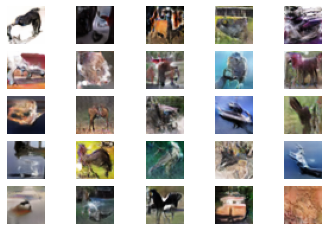

In [18]:
generator = load_model("generator_model_110.h5")
latent_points = generate_latent_points(100,50)
x = generator.predict(latent_points)
x = (x+1) / 2.0
for i in range(5*5):
  plt.subplot(5,5,i+1)
  plt.axis("off")
  plt.imshow(x[i,:,:])
plt.show()